**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers  <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Quadratic Nodal Finite Element](#mesh)
 + [Evaluation of Error](#Error)
 + [Setup](#setup)
 + [Tests](#Tests)
     - [No-Convection Case](#noconvection)
 
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of $700^{o}C$ and $1000^{o}C$. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing MSR, the primary tritium-producing reactions as follow

$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF $$
$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF + n' $$
$${^{19}_{9}}F + n → {^{17}_{8}}O + T $$
$${^{9}_{4}}BeF_2 + n → {^{4}_{2}}He + {^{4}_{2}}He + 2F $$


The production rate for the ternary fission reactions, seen above, in an FHR is given by Cisneros (2013). In addition to the production of tritium by ternary fission reactions, tritium is also produced by corrosion, where in an FHR the corrosion reaction (Oxidation of Cr) is given by. 

$$TF + Cr_{S.S} → CrF_2 + T_{2(g)} $$

Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as TRITium Diffusion EvolutionN and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


Consider tritium flowing co-currently, at steady-state, in the main coolant leg with fuel-salt at an initial concentration, u, and velocity, v. Tritium at the centerline of the bulk fluid is at its max concentration. Alternatively, no tritium is to be diffused into centerline. The latter case was considered in this model. Furthermore, sources indicate that tritium will diffuse into the pipe wall and the diffusion is limited by the mass transfer relation. The mass transfer coefficient was estimated using a Sherwood expression as such: 

$$Sh_{T_2,Pipe}=0.015Re^{0.83}Sc^{0.42}$$

The concentration of tritium in the pipe wall for an infinite slab was assumed to be 0. Lastly, no tritium was to diffuse at the exit flow. 

## [Problem Statement](#toc)<a id="problem"></a>


Consider the transport of tritium following a 2-D Poisson’s model 
\begin{align*}
-D\nabla^2 u +\vec{v}\nabla u = 0 \\
\end{align*}

Given that the convective term will be much greater than the diffusion in the z-axis it can be neglected. Additionaly, convection in the r-axis does not exist in Steady-State conditions. 
\begin{align*}
-\frac{1} {r} \frac{d} {dr}\ ( \ Dr \frac{du} {dr} \ ) \ + \vec{v} \frac{du}{dz} \ = 0. 
\end{align*}

such that for all $ u: [(z_a, z_b); (r_a, r_b)] ∈ Real → Real $. 
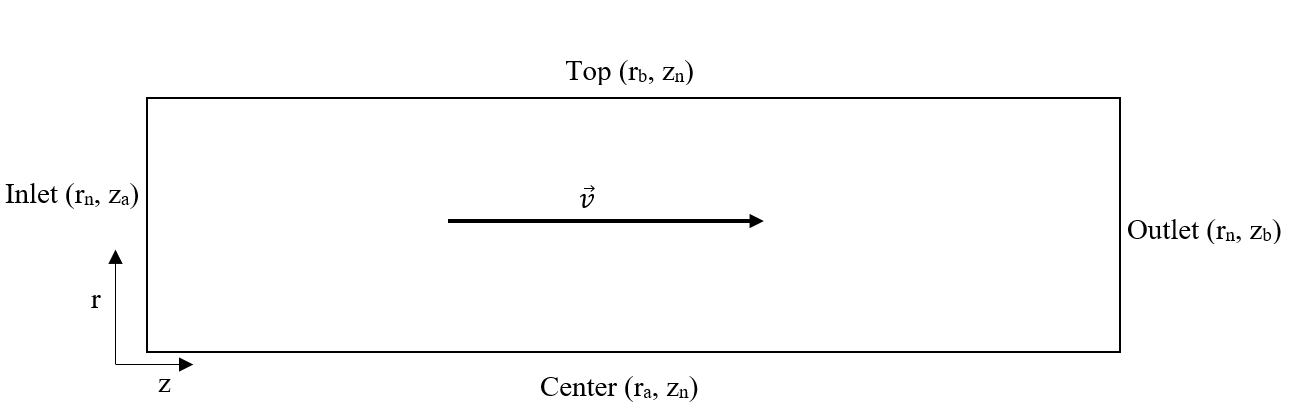

With the following Boundary Conditions \
[**Top**] : $ -q(r_b,z_n) = k(u(r)-u_\infty ) $ \
[**Center**] : $ q(r_a,z_n) = 0 $ \
[**Inlet**] : $ u(r_n,z_a) = a $ \
[**Outlet**] : $ q(r_n,z_b) = 0 $ 






In [1]:
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')



### new cell simple plot ###
pn.extension('vtk')  # this needs to be at the top of each cell for some reason

In [2]:
'''Domain'''

def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    height = 150
    radius = 7.5 
    coolant = pv.Cylinder(center=(0,0,0), direction=(1,0,0), height=height, radius=radius)

    plo = pv.Plotter(notebook=True,shape=(1,1)) 
    plo.add_mesh(coolant, color='red', opacity=1.0,)
   
    plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
    plo.set_viewup([0,1,0])
   
    cpos = plo.show(window_size=[800, 600])

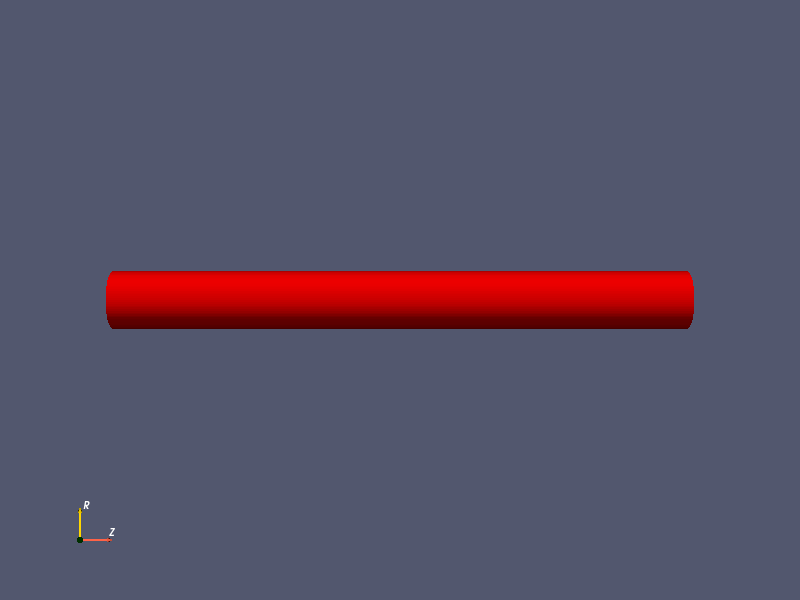

In [3]:
show_domain()

## [Objectives](#toc)<a id="obj"></a>

1.	Extend the Poisson convection-diffusion 1D problem to a 2D case.
2.	Develop the Galerkin Weak form of 2D Poisson convection-diffusion problem.
3.	Implement the Galerkin Weak form into MOOSE a FEM solver.



## [Approach](#toc)<a id="app"></a>

  1. Develop 2-D convection-diffusion Poisson problem
  2. Develop the Galerkin Weak form of 2D Poisson convection-diffusion problem.
  3. Implement the convection-diffusion problem into MOOSE 
  4. Isolate terms, convection and diffusion, to ensure accuracy of computation

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

<br>
 Poissons Convection-Diffusion Model:
\begin{align*}
-\frac{1} {r}\frac{d} {dr}(Dr\frac{du} {dr})+\vec{v} \frac{du}{dz} =-D\nabla^2 u +\vec{v}\nabla u = 0.   \ \ (1)
\end{align*}

Multiplying by wieghted test function $\varphi\ =u(r,z)$. Followed by integration over domain $\Omega$ 
\begin{align*}
\int_\Omega (\, -\varphi D\nabla^2 u+\varphi \vec{v}\cdot\nabla u)d\Omega = 0. \ \ (2)
\end{align*}

Integration of Diffusion Term requires by parts and utilization of divergance theorem:
\begin{align*}
\int_\Omega -\varphi D\nabla^2 ud\Omega &=\int_\Omega D \nabla \varphi \cdot \nabla u\ d\Omega -\int_{\ d\Omega\ }\ \varphi D(\vec{n}\cdot\nabla u)dA         \ \ \ \             (3)
\end{align*}

Substitution of (3) into (2), results in the **Galerkin weak formulation of the strong form** is as follows: 
\begin{align*}
\int_\Omega D \nabla \varphi \cdot \nabla u\ d\Omega+\int_\Omega\vec{v} \cdot\nabla u\ d\Omega\ -\int_{\ d\Omega\ } \varphi D(\vec{n}\cdot\nabla u)dA =0\ \ \ (4)
\end{align*}

The last term in (3) is the boundary condition normal to the domain (i.e outflow and inflow)

\begin{align*} 
\ D ( \vec{n} \cdot \nabla u \ ) \ = D ( \ n_r \frac{du}{dr}+n_z\frac{du}{dz} \ ) \ \ \ \ \ (5)
\end{align*}

Substitution of (5) and the following approximate solution into the wear form (4): 
\begin{align*}
u(r,z)= \sum_{j=1}^{NN}c_j\phi_j(r,z)\ \  \ \ \ \ (6)
\end{align*}

Along with selecting the weighted function to be the $i^{th}$ shape function, i.e $\varphi =\phi_i(r,z)$, results in a computational $i{th}$ linear algebraic residual equation for NN many nodal unknowns that MOOSE will solve computationally:

\begin{align*}
R_i(r,z)= \sum_{j=1}^{NN}c_j\int_\Omega 
[\phi_i ( V_r\frac{ \partial \phi_j }{\partial r} \ + V_z\frac{ \partial \phi_j }{\partial z} )\ + D\ (\frac{ \partial \phi_i }{\partial z} \frac{ \partial \phi_j }{\partial z} + \frac{ \partial \phi_i }{\partial r} \frac{ \partial \phi_j }{ \partial r}\ ) \ d \Omega \ ]
\ - \int_{\ d \Omega} \phi_i\ [\ D ( \ n_r \frac{du}{dr} \ + \ n_z \frac{du}{dz} \ ) \ ] \ dA  \ \ \ \ \ (7)
\end{align*}


### [MOOSE Kernels](#toc)<a id="kernels"></a>

In order to input the weak form of the receding problem statment into MOOSE, it must be written in inner product notation:

\begin{align*} 
( \nabla \varphi  , D \nabla u ) - < \varphi ,D \nabla u \cdot \vec{n} > + ( \varphi , \vec {v} \cdot \nabla u )=0. 
 \end{align*}

 Where, in MOOSE\
$ ( \nabla \varphi \ , \ D \nabla u\ )  = $ Kernel
 
$ < \varphi , D\nabla u\cdot \vec{n} > = $ Boundary Condition 

$ ( \varphi , \vec {v} \cdot \nabla u ) = $ Kernel 
 

Therefore the MOOSE kernels used in this project to solve the [weak form](#weakform) are as followed:


**Diffusion Kernel** : $(\nabla \varphi,D\nabla u)$

 + [DiffusionTerm.h](./include/kernels/X.h) and [DiffusionTerm.C](./src/kernels/X.C)
 
 
**Convection Kernel** : $ ( \varphi,\vec {v} \cdot \nabla u)$

 + [ConvectionTerm.h](./include/kernels/X.h) and [ConvectionTerm.C](./src/kernels/X.C).
 
**Boundary Conditions** : $ <\varphi,D\nabla u\cdot\vec{n}> $ 

[**Top**] - [NormalFluxBC.h](./include/kernels/X.h) and [NormalFluxBC.C](./src/kernels/X.C)
 
$-q(z_n, r_b) = k(u(r)-u_\infty ) $

[**Center**]-  MOOSE implemented NeumannBC 

$ q(z_n, r_a) = 0 $
 
[**Inlet**] - MOOSE implemented DirichletBC

$ u(z_a, r_n) = a $

[**Outlet**] - MOOSE implemented NeumannBC 

$ q(z_b, r_n) = 0 $



### [Quadratic Nodal Finite Element](#toc)<a id="mesh"></a>
Recall that Lagrange polynomials are not very flexible to approximate functions over a domain. Where to overcome this inflexibility, partitioning of the domain into "smaller" slices will often reach better convergence. For this domain Nine quadrilateral elements were used as the mesh of the pipe, which is most common amongst 2D FEM problems. A Nine quadrilateral element for a single element in both dimensions (r, z) follows:

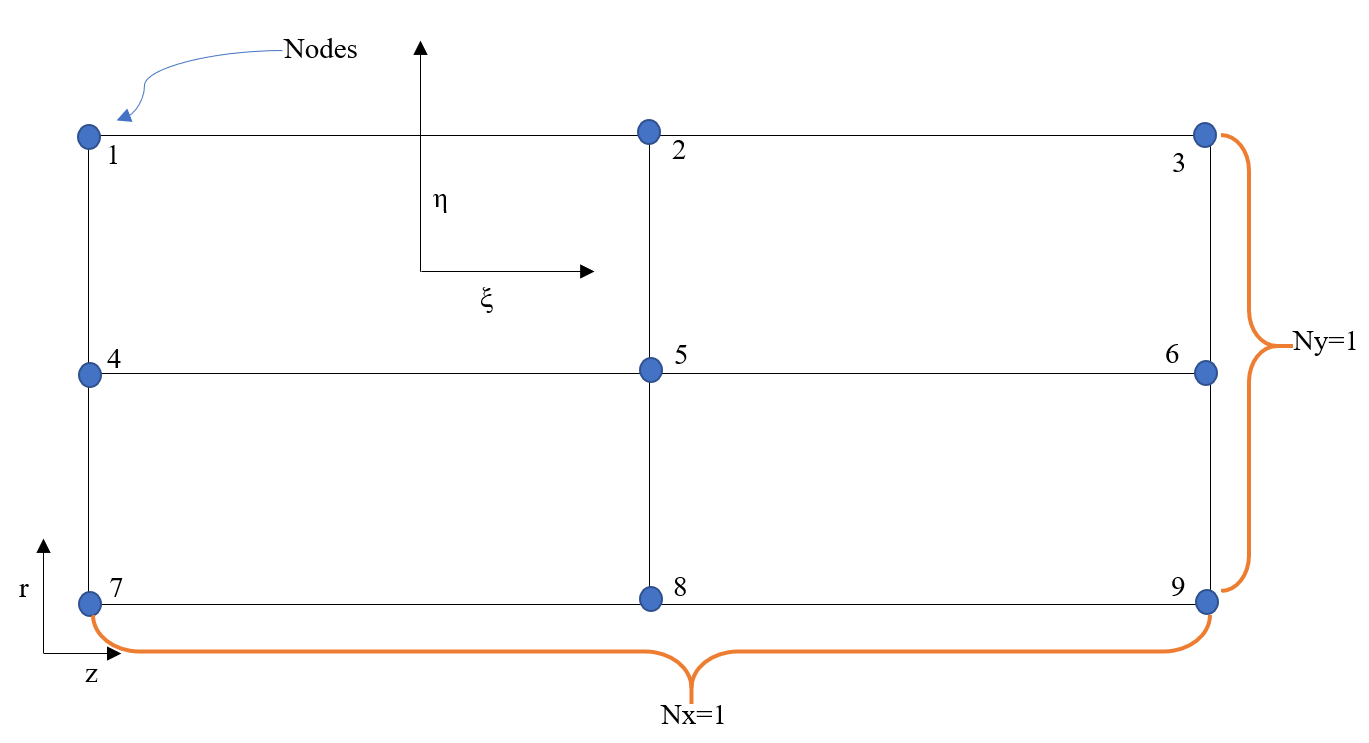

 
Where, the shape function $ \phi (\xi ,\eta )$ varies between $ N_{ij}  $ and follows the General form: 

$ \phi = A + B\xi + C\eta + D\eta\xi $

Partitioning of domain into smaller rectangles, as opposed to bilateral mesh, increases the approximated accuracy of the polynomials. 


### [Setup](#toc)<a id="setup"></a>

In [15]:
'''Domain'''

z_left = 0 #cm
z_right =150 #cm
r_bottom=0 #cm
r_top=7.5 #cm



'''Parameters'''
Re=10
diff_coeff = .000266493 #cm2/s
s_source = 0
fluid_density= 1940.8544 #kg/m3
fluid_viscosity=0.00158871 #Pa-s



    
vel=(Re*fluid_viscosity)/(fluid_density*(2*r_top/100))*100
print('velocity of fluid '+ '= ' + str(vel)+ ' cm/s ')

schmidt_number=(fluid_viscosity)/(fluid_density*(diff_coeff/10000))
print('The Schmidt Number of the fluid =  ' + str(schmidt_number))

Sherwood_exp1=0.015*pow(Re,0.83)*pow(schmidt_number,0.42)
print('The Sherwood Number using the expression in the introduction =   ' + str(Sherwood_exp1))

Mass_transfer_coeff=(Sherwood_exp1*diff_coeff)/(2*r_top)
print('The Mass Transfer Coeffient =  ' + str(Mass_transfer_coeff)+'  cm/s')

Peclet_Number=r_top*vel/diff_coeff
print('The Peclet Number of the fluid =  ' + str(Peclet_Number))




velocity of fluid = 0.0054570811700249125 cm/s 
The Schmidt Number of the fluid =  30.716085432027736
The Sherwood Number using the expression in the introduction =   0.4273511954100537
The Mass Transfer Coeffient =  7.592406807894097e-06  cm/s
The Peclet Number of the fluid =  153.5804271601387


In [16]:
'''Data (boundary conditions)'''

u_inlet = 3.6e-07 #ug/cc
q_center=0 #ug/cm^2
q_bottom=0 #ug/cm^2
ambient_conc = 0 #ug/cm^2
velocity=[vel,0,0] #cm/s
print(vel)
Mass_transfer_coef= Mass_transfer_coeff #cm/s
print(Mass_transfer_coef)

0.0054570811700249125
7.592406807894097e-06


### [Tests](#toc)<a id="tests"></a>

#### [No-Convection](#toc)<a id="noconvection"></a>

In [6]:
!cat NoConvection.hit


# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 11Apr21 15:22:32

# Parameters [cm]
xmin = 0
xmax = 150 
ymin = 0
ymax = 7.5
diff_coeff =  .000266493 #Diffusion of Tritium in Bulk Fluid
source_s = 0
mesh_type=QUAD9
n_felem_x=50
n_felem_y=100

degree=Second
flux_exit = 0   # Tritium is completely removed before leaving outflow
u_inlet = 3.6e-07   #Concentration of Tritium in the bulk fluid at inlet
velocity = '0 0 0' #Velocity of fluid taken from RE 10,000 
flux_center= 0
Mass_transfer_coeff= 0.0023462780080220212
Ambient_conc = 0

[Problem]
  type = FEProblem
   coord_type = RZ
   rz_coord_axis = X  #Revolve around the x axis (y is now radius)
   
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    
	
	
	nx=${replace n_felem_x}
	ny=${replace n_felem_y}
	elem_type=${replace mesh_type}
   
	
  []
[]

[V

In [7]:
!./engy5310p1-opt -i NoConvection.hit 



Framework Information:
MOOSE Version:           git commit 6fac045ef1 on 2021-02-25
LibMesh Version:         
PETSc Version:           3.14.2
SLEPc Version:           3.14.0
Current Time:            Mon May 10 11:00:48 2021
Executable Timestamp:    Sat May  8 16:47:55 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 20301
    Local:                 20301
  Elems:                   
    Total:                 5000
    Local:                 5000
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                20301
  Num Local DOFs:          20301
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                30000
  Num Local DOFs:          30000
  Variables:              

In [10]:
'''Plot function for FEM Solution'''

def plot_solution_noconvec(df,
                  dimension='Null',
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import math
    import numpy as np
    plt.style.use('dark_background')
    radial ="r" 
    axial="z"
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    
    #radial plot
    
  
    x = np.linspace(0, 7.5, 50)
    y = (3.6e-07)*np.exp((-0.0023462780080220212/.000266493)*x)
    y2 = (3.6e-07)*np.exp((-0.000146/ .000266493)*x)
    ax1.plot(df['y'], df['u'],'r*-',label=basis_functions_type)
    ax1.plot(x, y,'b*-',label='Exact Solution k/D = 1.38')
    ax1.plot(x, y2,'g*-',label='Exact Solution k/D = .54887')
    ax1.set_xlabel(r'$r$ ', fontsize=18)
    ax1.set_ylabel(r'$u_h(r)$ [µg/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center right', fontsize=12)
    ax1.grid(True)
        
    
   
    
   

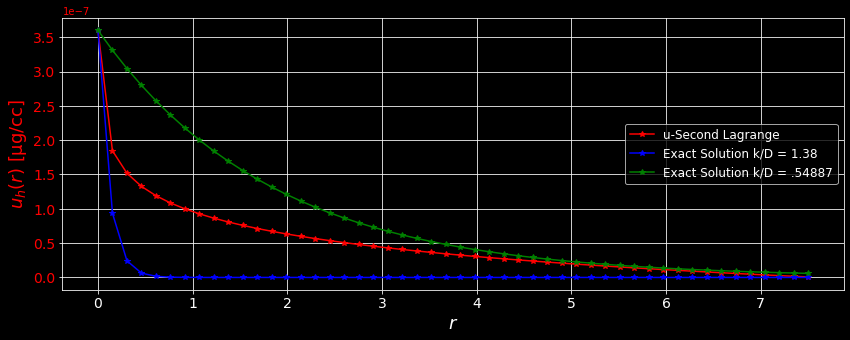

In [11]:
import pandas as pd
df = pd.read_csv('out-radial-noconvec_radial-line_0002.csv')

    
plot_solution_noconvec(df, dimension='r', title='Radial Plot FEM Solution z=zmax ', basis_functions_type='u-Second Lagrange', flux_basis_functions_type='Exact solution')

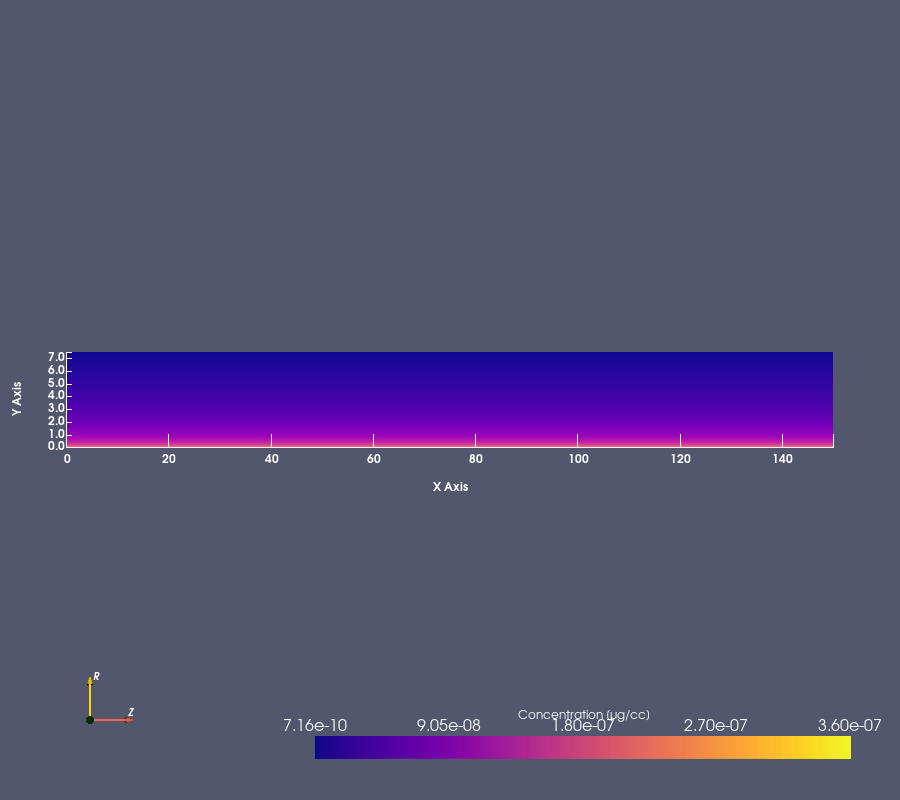

In [12]:

'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out-noconvec_000_0.vtu')

plo = pv.Plotter()   

plo.add_mesh(poisson, scalars='u', cmap='plasma', stitle='Concentration [µg/cc]')


plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
plo.show_bounds()
plo.set_scale(xscale=2, yscale=5, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


In [13]:
!cat input.hit

# Tritium Transport: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Student :Anthony Bowers
# Personal Instructor (PI):Dr. Shubash Sharma
# Date: 5/3/2021

# Parameters [cm]
xmin = 0
xmax = 150 
ymin = 0
ymax = 7.5
diff_coeff =  0.0054570811700249125 #Diffusion of Tritium in Bulk Fluid
source_s = 0
mesh_type=QUAD9
n_felem_x=250
n_felem_y=250

degree=Second
flux_exit = 0   # Tritium is completely removed before leaving outflow
u_inlet = 3.6e-07   #Concentration of Tritium in the bulk fluid at inlet
velocity = '0.054570811700249126 0 0' #Velocity of fluid taken from RE 10,000 
flux_center= 0
<<<<<<< HEAD
mass_transfer_coeff= 4.27e-06
ambient_conc = 0
Mass_transfer_coeff= 7.592406807894097e-06
Ambient_conc = 0
>>>>>>> anthony

[Problem]
  type = FEProblem
  coord_type = RZ
  rz_coord_axis = X  #Revolve around the x axis (y is now radius)
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace 

In [19]:
!./engy5310p1-opt -i input.hit 



Framework Information:
MOOSE Version:           git commit 6fac045ef1 on 2021-02-25
LibMesh Version:         
PETSc Version:           3.14.2
SLEPc Version:           3.14.0
Current Time:            Mon May 10 11:04:05 2021
Executable Timestamp:    Sat May  8 16:47:55 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 251001
    Local:                 251001
  Elems:                   
    Total:                 62500
    Local:                 62500
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                251001
  Num Local DOFs:          251001
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                375000
  Num Local DOFs:          375000
  Variables:      

## [Results and Analysis](#toc)<a id="ranalysis"></a>

In [20]:

'''Plot function for FEM Solution'''

def plot_solution(df,
                  dimension='Null',
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import numpy as np
    plt.style.use('dark_background')
    radial ="r" 
    axial="z"
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    
    #radial plot
    
    if (radial == dimension):
        ax1.plot(df['y'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$r$ ', fontsize=18)
        ax1.set_ylabel(r'$u_h(r)$ [µg/cc]', fontsize=18, color='red')
        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
        
        ax2 = ax1.twinx()
        ax2.plot(df['y'], df['diffFluxU_radius'],'b*-',label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(r)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        
    #Axial plot   
    
    if (axial == dimension):
        ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$z$ [cm]', fontsize=18)
        ax1.set_ylabel(r'$u_h(z)$ [µg/cc]', fontsize=18, color='red')

        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
            
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_axial'],'b*-',label=flux_basis_functions_type)
        
        ax2.set_ylabel(r"$q_h(x)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
      



    plt.title(title, fontsize=20)
  
    plt.show()
    print('')

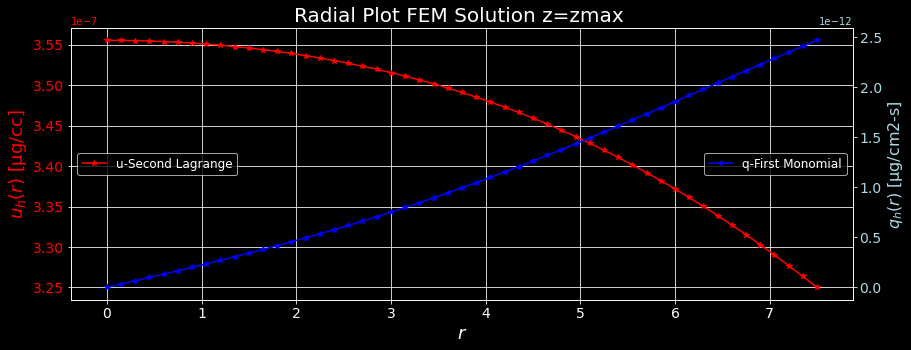

In [21]:
import pandas as pd
df = pd.read_csv('out-radial_radial-line_0002.csv')

    
plot_solution(df, dimension='r', title='Radial Plot FEM Solution z=zmax ', basis_functions_type='u-Second Lagrange', flux_basis_functions_type='q-First Monomial')

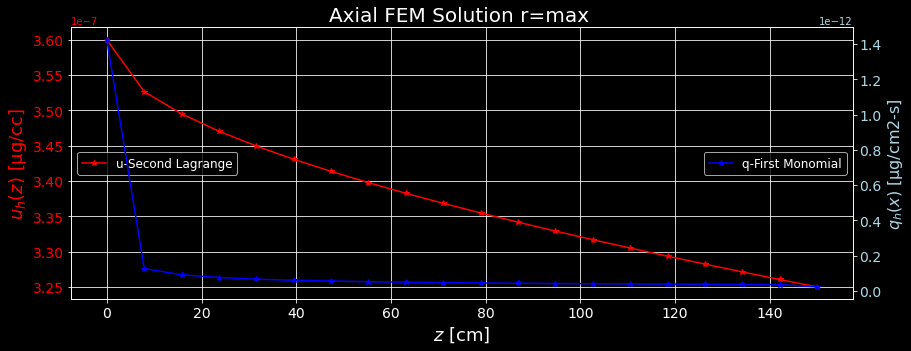

In [22]:
import pandas as pd
df = pd.read_csv('out-axial_axial-line_0002.csv')

    
plot_solution(df, dimension='z', title='Axial FEM Solution r=max ', basis_functions_type='u-Second Lagrange',flux_basis_functions_type='q-First Monomial')

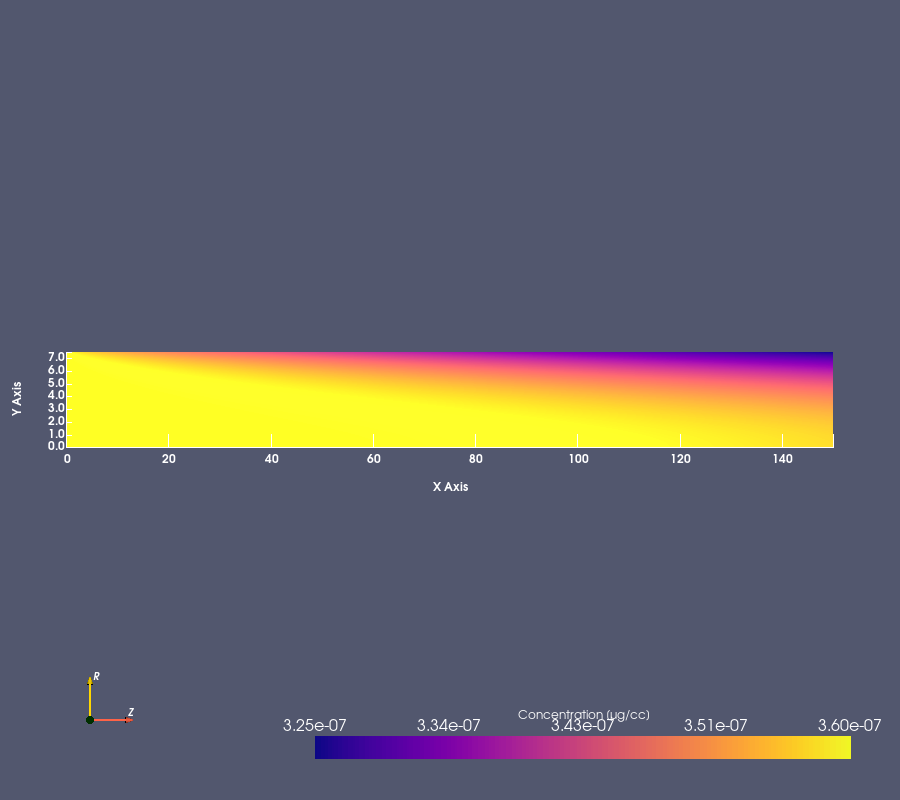

In [23]:

'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')

plo = pv.Plotter()   

plo.add_mesh(poisson, scalars='u', cmap='plasma', stitle='Concentration [µg/cc]')


plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
plo.show_bounds()
plo.set_scale(xscale=2, yscale=5, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


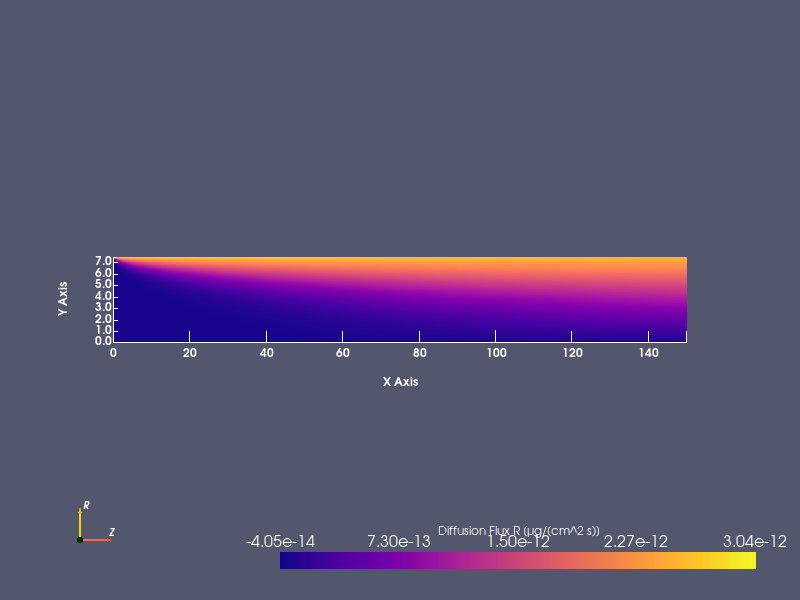

In [25]:
'''Show 2D solution'''

import pyvista as pv

poisson = pv.read('out_000_0.vtu')

plo = pv.Plotter()   
plo.add_mesh(poisson, scalars='diffFluxU_radius', cmap='plasma', stitle='Diffusion Flux R [µg/(cm^2 s)]')
plo.add_axes(xlabel='Z', ylabel='R', zlabel='')


plo.show_bounds()
plo.set_scale(xscale=None, yscale=3, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])

cpos = plo.show(window_size=[800, 600])


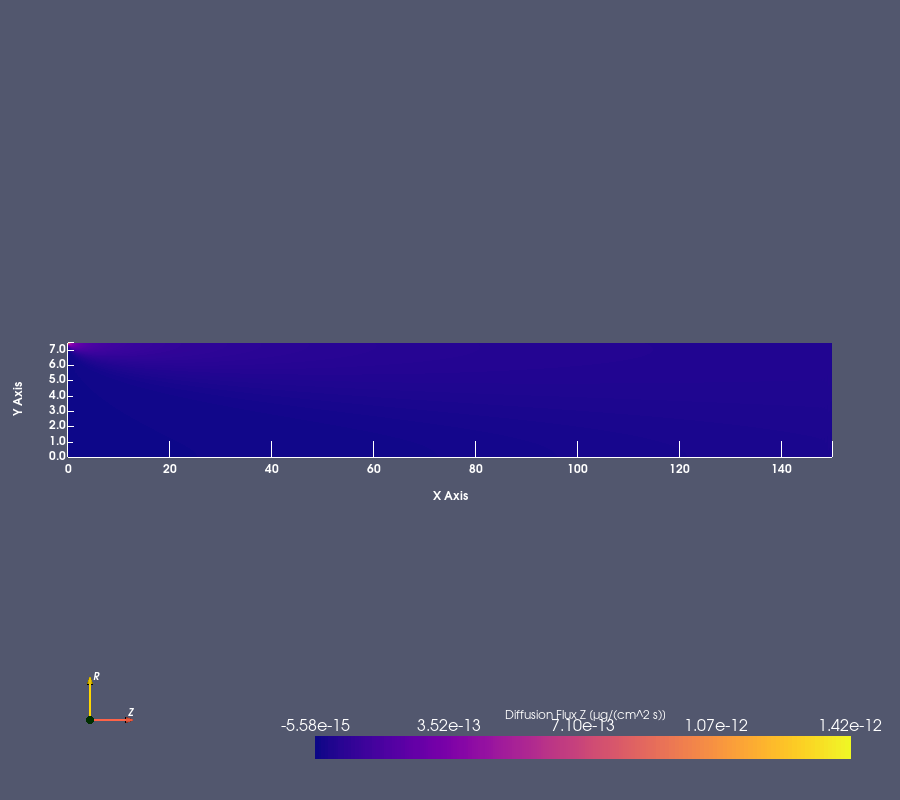

In [27]:
'''Show 2D solution'''

import pyvista as pv

poisson = pv.read('out_000_0.vtu')
plo = pv.Plotter()   
plo.add_mesh(poisson, scalars='diffFluxU_axial', cmap='plasma', stitle='Diffusion Flux Z [µg/(cm^2 s)]')
plo.add_axes(xlabel='Z', ylabel='R', zlabel='')

plo.set_scale(xscale=None, yscale=3, zscale=None, reset_camera=True)
plo.show_bounds()
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


In [135]:
!cat Actual.hit


# Tritium Transport: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Student :Anthony Bowers
# Personal Instructor (PI):Dr. Shubash Sharma
# Date: 5/3/2021



# Parameters [cm]
xmin = 0
xmax = 150 
ymin = 0
ymax = 7.5
diff_coeff =  .000266493 #Diffusion of Tritium in Bulk Fluid
source_s = 0
mesh_type=QUAD9
n_felem_x=1
n_felem_y=250

degree=Second
flux_exit = 0   # Tritium is completely removed before leaving outflow
u_inlet = 3.6e-07   #Concentration of Tritium in the bulk fluid at inlet
velocity = '5.45 0 0' #Velocity of fluid taken from RE 10,000 
flux_center= 0
Mass_transfer_coeff= 0.002346
Ambient_conc = 0

[Problem]
  type = FEProblem
   coord_type = RZ
   rz_coord_axis = X  #Revolve around the x axis (y is now radius)
   
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    
	
	
	nx=${replace n_felem_x}
	ny=${replace n_felem_y}
	elem_type=${repl

In [28]:
!./engy5310p1-opt -i Actual.hit 



Framework Information:
MOOSE Version:           git commit 6fac045ef1 on 2021-02-25
LibMesh Version:         
PETSc Version:           3.14.2
SLEPc Version:           3.14.0
Current Time:            Mon May 10 11:05:32 2021
Executable Timestamp:    Sat May  8 16:47:55 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 1503
    Local:                 1503
  Elems:                   
    Total:                 250
    Local:                 250
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                1503
  Num Local DOFs:          1503
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                1500
  Num Local DOFs:          1500
  Variables:               { "diff

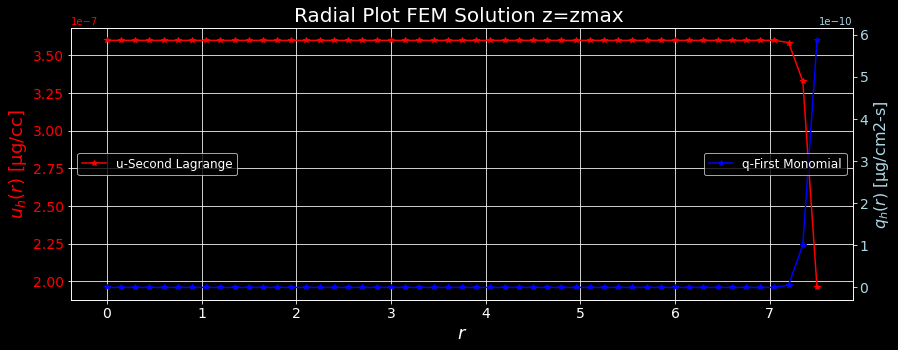

In [29]:
import pandas as pd
df = pd.read_csv('out-radial-actual_radial-line_0002.csv')

    
plot_solution(df, dimension='r', title='Radial Plot FEM Solution z=zmax ', basis_functions_type='u-Second Lagrange', flux_basis_functions_type='q-First Monomial')

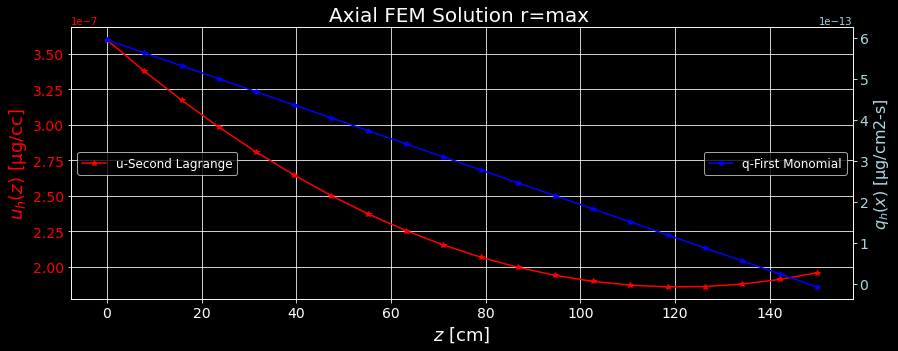

In [30]:
import pandas as pd
df = pd.read_csv('out-axial-actual_axial-line_0002.csv')

    
plot_solution(df, dimension='z', title='Axial FEM Solution r=max ', basis_functions_type='u-Second Lagrange',flux_basis_functions_type='q-First Monomial')

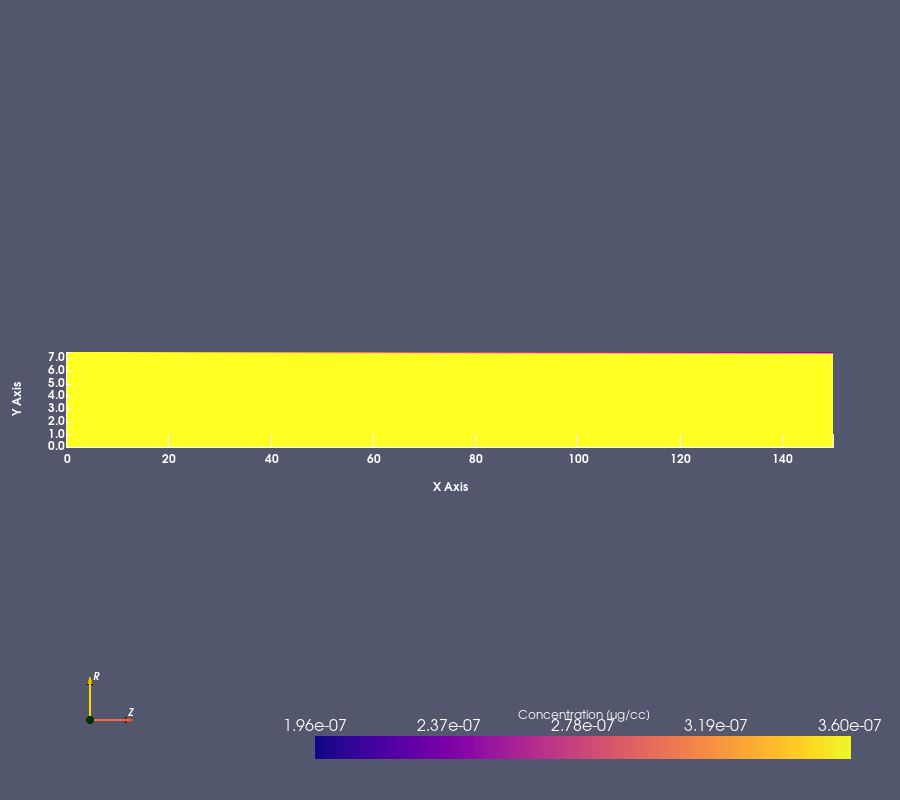

In [31]:

'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out-actual_000_0.vtu')

plo = pv.Plotter()   

plo.add_mesh(poisson, scalars='u', cmap='plasma', stitle='Concentration [µg/cc]')


plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
plo.show_bounds()
plo.set_scale(xscale=2, yscale=5, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


## [Conclusions](#toc)<a id="conclusions"></a>

The results shown, shows the transport of tritium in a pipe. It was assumed that the diffusion in the z direction is to be completely neglectable due to the Peclet Number, ratio of convection to diffusion, being in the order of $10^5$ magnitude. The significance of the convection term relative to diffusion it was best described by changing the RE number from 10,000 to 10. At the higher end of the RE number, the concentration remains constant up until the surface of the pipe is met, where it drops too significantly. Whereas, in applying the lower end of the RE number the concentration drop is more gradual. 
This result makes sense, because under steady state computation we are solving for the point at which flow becomes fully developed. Therefore, the results will be representative of the entrance length and fully developed flow, by the boundary layer. 

Where we must recall that the boundary layer is the layer of fluid in the immediate vicinity of a bounding surface where the effects of viscosity are significant. The boundary layer is described by the Newtonian fluid viscous force profile $F=\mu A \frac{v}{y} $. Since the boundary layer is in terms of velocity, which can be substituted for concentration, the results of u will show the formulation of the boundary layer from entrance length to fully developed. 


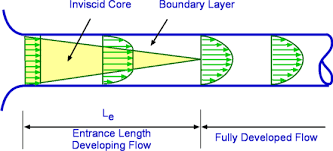

For higher Reynolds number the boundary layer will be less prominate since the viscous force is much greater. Whereas under lower Reynolds number the boundary layer will be more prominate since the viscous force is much less.  


## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310),  University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] Stempien D. John, “Tritium Transport, Corrosion, and Fuel Performance Modeling in Fluoride Salt-Cooled High-Temperature Reactor (FHR)”. Massachusetts Institute of Technology. PDF. June 2017
- [4] R. Serrano-Lópeza, J. Fraderaa, S. Cuesta-Lópeza. “Molten salts database for energy applications”. PDF. September 2014.